In [1]:
import matplotlib.pyplot as plt
import numpy as mp

In [2]:
import pandas as pd

StockPrices = pd.DataFrame()
market_value_list=[]
StockPrices.index.name = 'date'
gold = pd.read_csv('./code/data/LBMA-GOLD.csv')
bits = pd.read_csv('./code/data/BCHAIN-MKPRU.csv')
StockPrices['gold'] = gold['Price']
StockPrices['bits'] = bits['Value']
print(StockPrices.head())



         gold    bits
date                 
0     1324.60  621.65
1     1323.65  609.67
2     1321.75  610.92
3     1310.80  608.82
4     1308.35  610.38


In [3]:
StockReturns = StockPrices.pct_change().dropna()
print(StockReturns.head())


          gold      bits
date                    
1    -0.000717 -0.019271
2    -0.001435  0.002050
3    -0.008284 -0.003437
4    -0.001869  0.002562
5     0.004968 -0.002081


          gold      bits  Portfolio
date                               
1    -0.000717 -0.019271  -0.011850
2    -0.001435  0.002050   0.000656
3    -0.008284 -0.003437  -0.005376
4    -0.001869  0.002562   0.000790
5     0.004968 -0.002081   0.000739


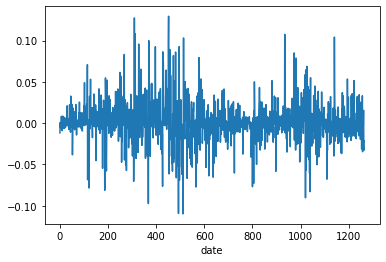

In [4]:
import numpy as np
# 将收益率数据拷贝到新的变量 stock_return 中，这是为了后续调用的方便
stock_return = StockReturns.copy()

# 设置组合权重，存储为numpy数组类型
portfolio_weights = np.array([0.4, 0.6])
# 计算加权的股票收益
WeightedReturns = stock_return.mul(portfolio_weights, axis=1)
# 计算投资组合的收益
StockReturns['Portfolio'] = WeightedReturns.sum(axis=1)
# 打印前5行数据
print(StockReturns.head())

# 绘制组合收益随时间变化的图
StockReturns.Portfolio.plot()
plt.show()

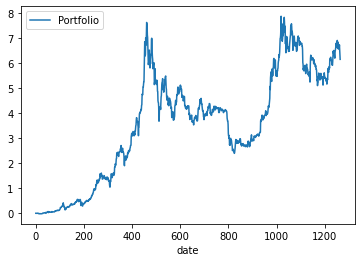

In [5]:
# 定义累积收益曲线绘制函数
def cumulative_returns_plot(name_list):
    for name in name_list:
        CumulativeReturns = ((1+StockReturns[name]).cumprod()-1)
        CumulativeReturns.plot(label=name)
    plt.legend()
    plt.show()
# 计算累积的组合收益，并绘图
cumulative_returns_plot(['Portfolio'])

Traceback (most recent call last):
  File "/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug/pydev_jupyter_utils.py", line 64, in attach_to_debugger
    debugger.prepare_to_run(enable_tracing_from_start=False)
TypeError: prepare_to_run() got an unexpected keyword argument 'enable_tracing_from_start'
Failed to connect to target debugger.


          gold      bits  Portfolio  Portfolio_EW
date                                             
1    -0.000717 -0.019271  -0.011850     -0.009994
2    -0.001435  0.002050   0.000656      0.000307
3    -0.008284 -0.003437  -0.005376     -0.005861
4    -0.001869  0.002562   0.000790      0.000347
5     0.004968 -0.002081   0.000739      0.001444


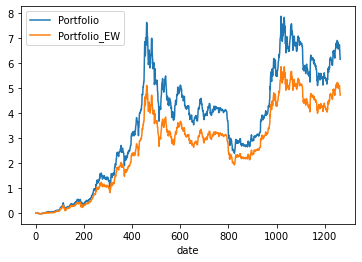

In [6]:
# 设置投资组合中股票的数目
numstocks = 2
# 平均分配每一项的权重
portfolio_weights_ew = np.repeat(1/numstocks, numstocks)
# 计算等权重组合的收益
StockReturns['Portfolio_EW'] = stock_return.mul(portfolio_weights_ew, axis=1).sum(axis=1)
# 打印前5行数据
print(StockReturns.head())
# 绘制累积收益曲线
cumulative_returns_plot(['Portfolio', 'Portfolio_EW'])


          gold      bits
gold  1.000000  0.046532
bits  0.046532  1.000000


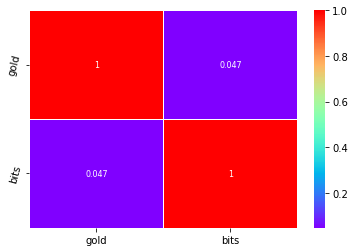

In [7]:
# 计算相关矩阵
correlation_matrix = stock_return.corr()
# 输出相关矩阵
print(correlation_matrix)
import seaborn as sns
#创建热图
sns.heatmap(correlation_matrix,annot=True,cmap='rainbow',linewidths=1.0,annot_kws={'size':8})
plt.xticks(rotation=0)
plt.yticks(rotation=75)
plt.show()

In [8]:
# 计算协方差矩阵
cov_mat = stock_return.cov()
# 年化协方差矩阵
cov_mat_annual = cov_mat * 252
# 输出协方差矩阵
print(cov_mat_annual)

          gold      bits
gold  0.018901  0.004136
bits  0.004136  0.417992


In [9]:
# 计算投资组合的标准差
portfolio_volatility = np.sqrt(np.dot(portfolio_weights.T, np.dot(cov_mat_annual, portfolio_weights)))
print(portfolio_volatility)

0.3943177813100978


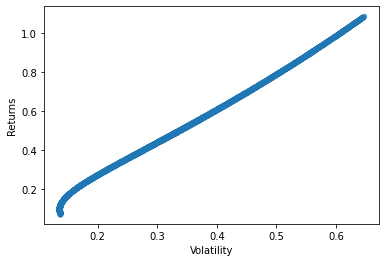

In [15]:
ticker_list = ['gold', 'bits']
# 设置模拟的次数
number = 10000
# 设置空的numpy数组，用于存储每次模拟得到的权重、收益率和标准差
random_p = np.empty((number, 4))
# 设置随机数种子，这里是为了结果可重复
np.random.seed(4)

#循环模拟10000次随机的投资组合
for i in range(number):
    #生成5个随机数，并归一化，得到一组随机的权重数据
    random2=np.random.random(2)
    random_weight=random2/np.sum(random2)

    #计算年平均收益率
    mean_return=stock_return.mul(random_weight,axis=1).sum(axis=1).mean()
    annual_return=(1+mean_return)**252-1

    #计算年化标准差，也成为波动率
    random_volatility=np.sqrt(np.dot(random_weight.T,np.dot(cov_mat_annual,random_weight)))

    #将上面生成的权重，和计算得到的收益率、标准差存入数组random_p中
    random_p[i][:2]=random_weight
    random_p[i][2]=annual_return
    random_p[i][3]=random_volatility

#将Numpy数组转化为DataF数据框
RandomPortfolios=pd.DataFrame(random_p)
#设置数据框RandomPortfolios每一列的名称
RandomPortfolios.columns=[ticker +'_weight' for ticker in ticker_list]+['Returns','Volatility']

#绘制散点图
RandomPortfolios.plot('Volatility','Returns',kind='scatter',alpha=0.3)
plt.show()

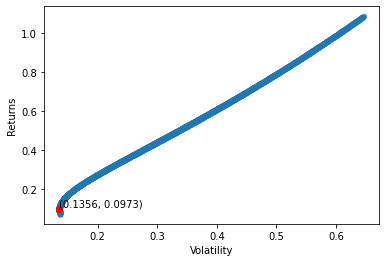

In [16]:
# 找到标准差最小数据的索引值
min_index = RandomPortfolios.Volatility.idxmin()

# 在收益-风险散点图中突出风险最小的点
RandomPortfolios.plot('Volatility', 'Returns', kind='scatter', alpha=0.3)
x = RandomPortfolios.loc[min_index,'Volatility']
y = RandomPortfolios.loc[min_index,'Returns']
plt.scatter(x, y, color='red')
#将该点坐标显示在图中并保留四位小数
plt.text(np.round(x,4),np.round(y,4),(np.round(x,4),np.round(y,4)),ha='left',va='bottom',fontsize=10)
plt.show()


In [17]:
# 提取最小波动组合对应的权重, 并转换成Numpy数组
GMV_weights = np.array(RandomPortfolios.iloc[min_index, 0:numstocks])
# 计算GMV投资组合收益
StockReturns['Portfolio_GMV'] = stock_return.mul(GMV_weights, axis=1).sum(axis=1)
#输出风险最小投资组合的权重
print(GMV_weights)

[0.96560965 0.03439035]


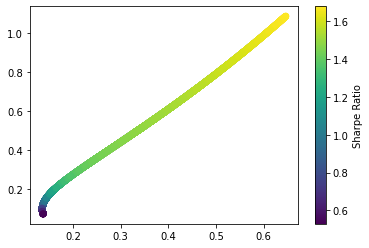

In [18]:
# 设置无风险回报率为0
risk_free = 0
# 计算每项资产的夏普比率
RandomPortfolios['Sharpe'] = (RandomPortfolios.Returns - risk_free) / RandomPortfolios.Volatility
# 绘制收益-标准差的散点图，并用颜色描绘夏普比率
plt.scatter(RandomPortfolios.Volatility, RandomPortfolios.Returns, c=RandomPortfolios.Sharpe)
plt.colorbar(label='Sharpe Ratio')
plt.show()

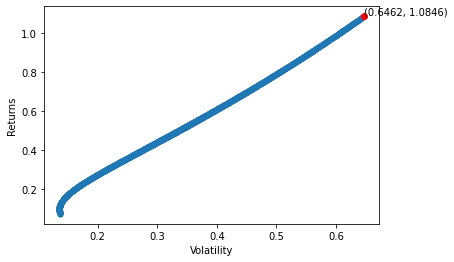

In [19]:
# 找到夏普比率最大数据对应的索引值
max_index = RandomPortfolios.Sharpe.idxmax()
# 在收益-风险散点图中突出夏普比率最大的点
RandomPortfolios.plot('Volatility', 'Returns', kind='scatter', alpha=0.3)
x = RandomPortfolios.loc[max_index,'Volatility']
y = RandomPortfolios.loc[max_index,'Returns']
plt.scatter(x, y, color='red')
#将该点坐标显示在图中并保留四位小数
plt.text(np.round(x,4),np.round(y,4),(np.round(x,4),np.round(y,4)),ha='left',va='bottom',fontsize=10)
plt.show()

In [20]:
# 提取最大夏普比率组合对应的权重，并转化为numpy数组
MSR_weights = np.array(RandomPortfolios.iloc[max_index, 0:numstocks])
# 计算MSR组合的收益
StockReturns['Portfolio_MSR'] = stock_return.mul(MSR_weights, axis=1).sum(axis=1)
#输出夏普比率最大的投资组合的权重
print(MSR_weights)

[4.26641516e-04 9.99573358e-01]
